Alzheimers Prediction Model using CNN

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

Defining the Directory Path and iterating through subfloders of said Directory to create the data-frame(df) 

In [2]:
dataset_path = 'C:\\Users\\Krishang Virmani\\Desktop\\Python CB\\ADNI\\Alzheimer_s Dataset'

images = []
labels = []


for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    
    
    if os.path.isdir(subfolder_path):
        
        for folder in os.listdir(subfolder_path):
            folder_path = os.path.join(subfolder_path, folder)
            
            
            if os.path.isdir(folder_path):
                
                for image_filename in os.listdir(folder_path):
                   
                    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        image_path = os.path.join(folder_path, image_filename)
                        images.append(image_path)
                        labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})


In [3]:
df

image             label
0     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
1     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
2     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
3     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
4     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
...                                                 ...               ...
6395  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6396  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6397  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6398  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6399  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented

[6400 rows x 2 columns]

Visualizing Number of samples in each of the classes

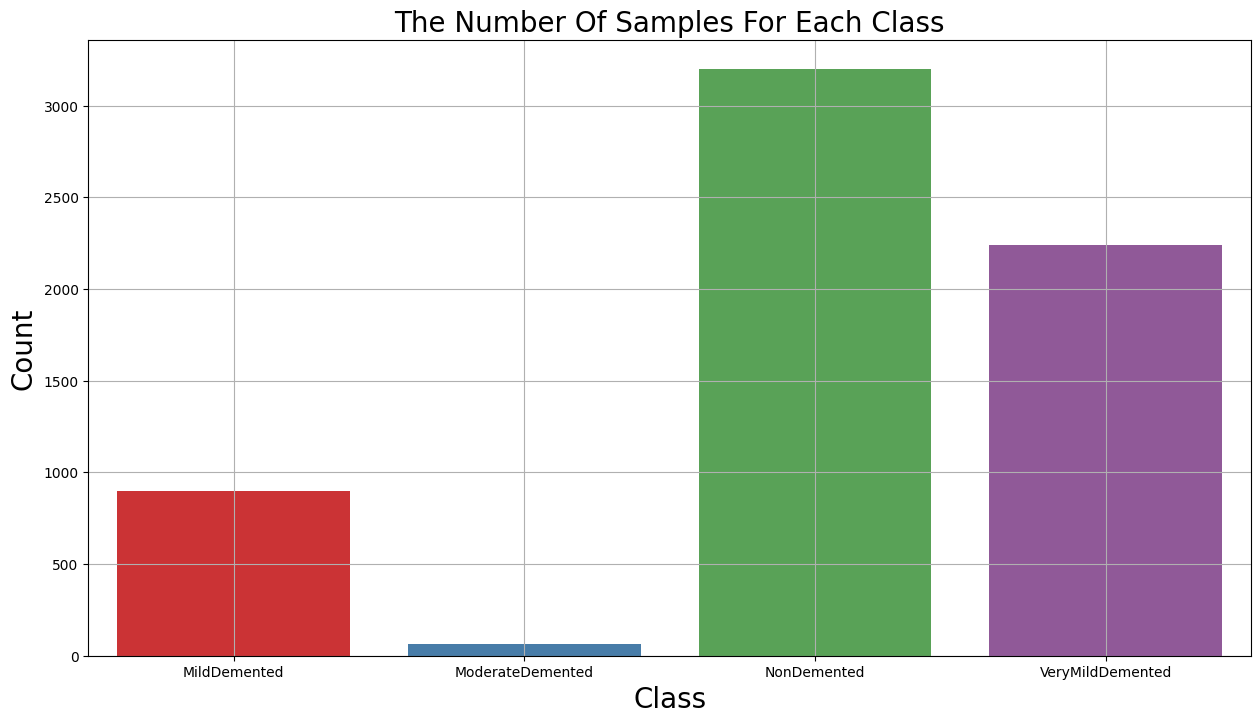

In [4]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1',hue=df.label,legend=False)
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.show()

Random Images from the Dataset including their Labels

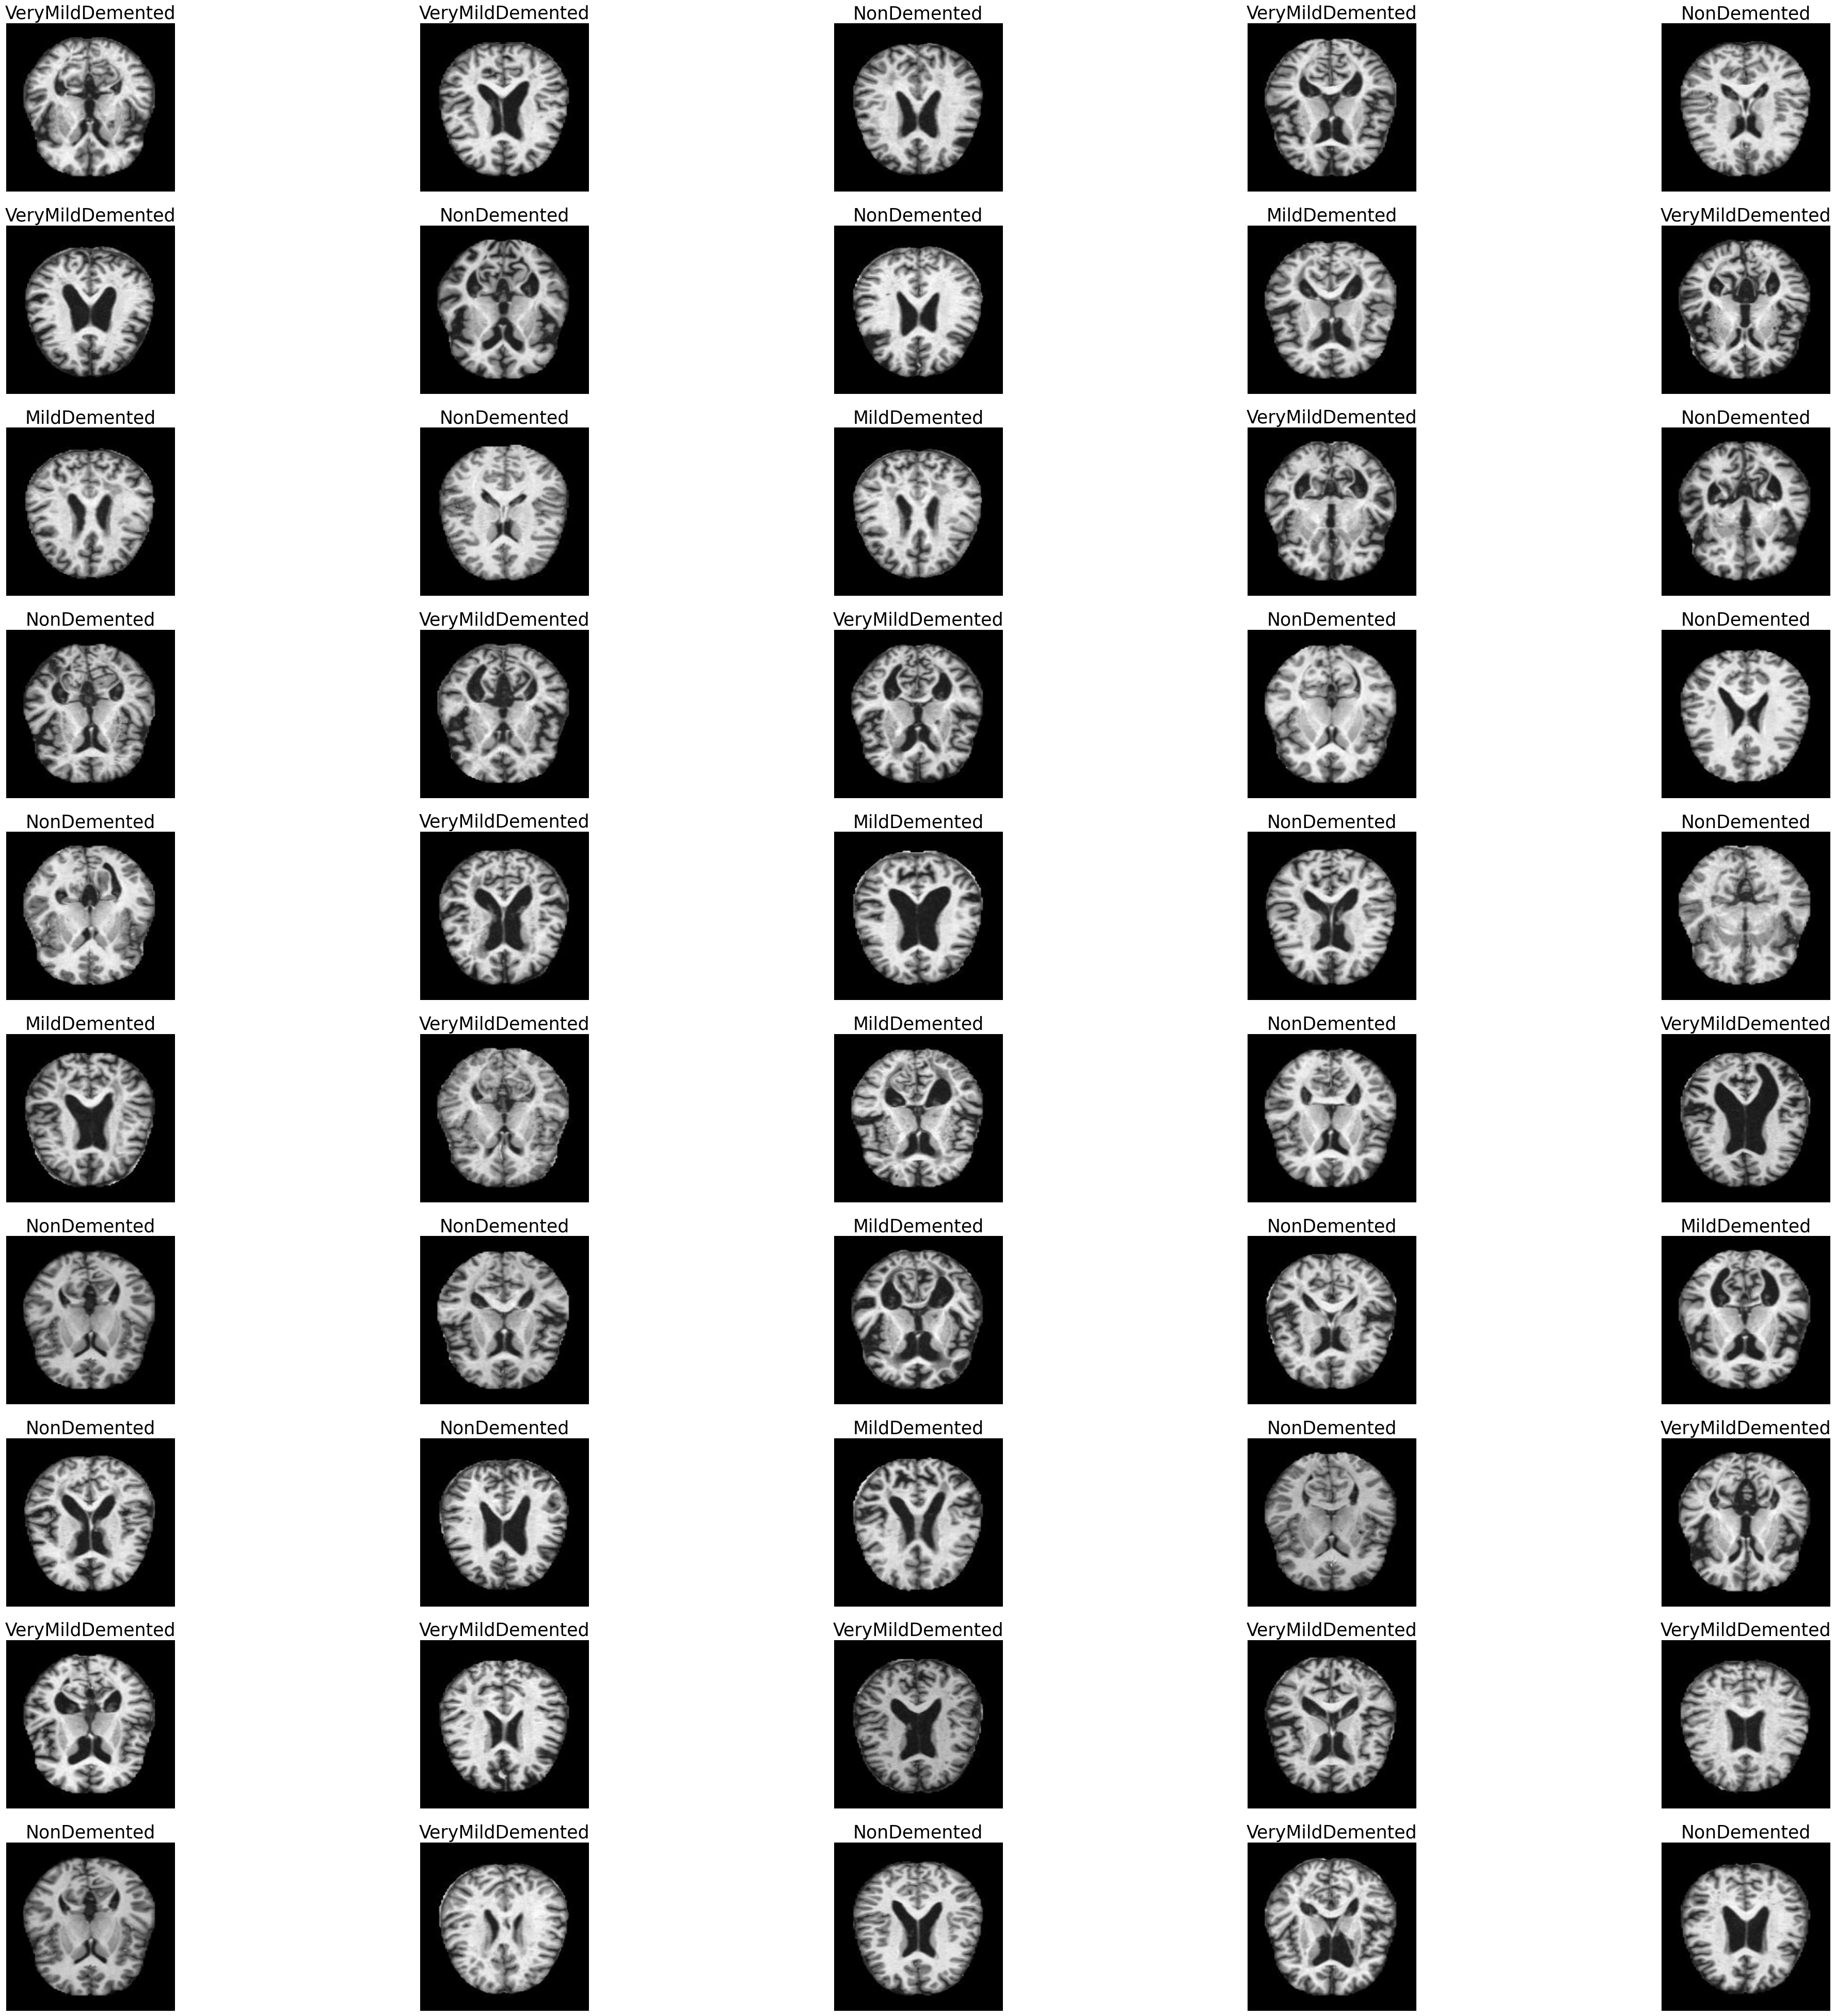

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

Setting up a data generator for training data from a DataFrame, resizing the images, and rescaling the pixel values

In [6]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [7]:
train_data, train_labels = train_data_gen.next()

In [8]:
class_num=np.sort(['Alzheimer_s disease','Cognitively normal','Early mild cognitive impairment','Late mild cognitive impairment'])


In [9]:
class_num

array(['Alzheimer_s disease', 'Cognitively normal',
       'Early mild cognitive impairment',
       'Late mild cognitive impairment'], dtype='<U31')

Addressing class imbalance in the training data using SMOTE (Synthetic Minority Over-sampling Technique) 

In [10]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


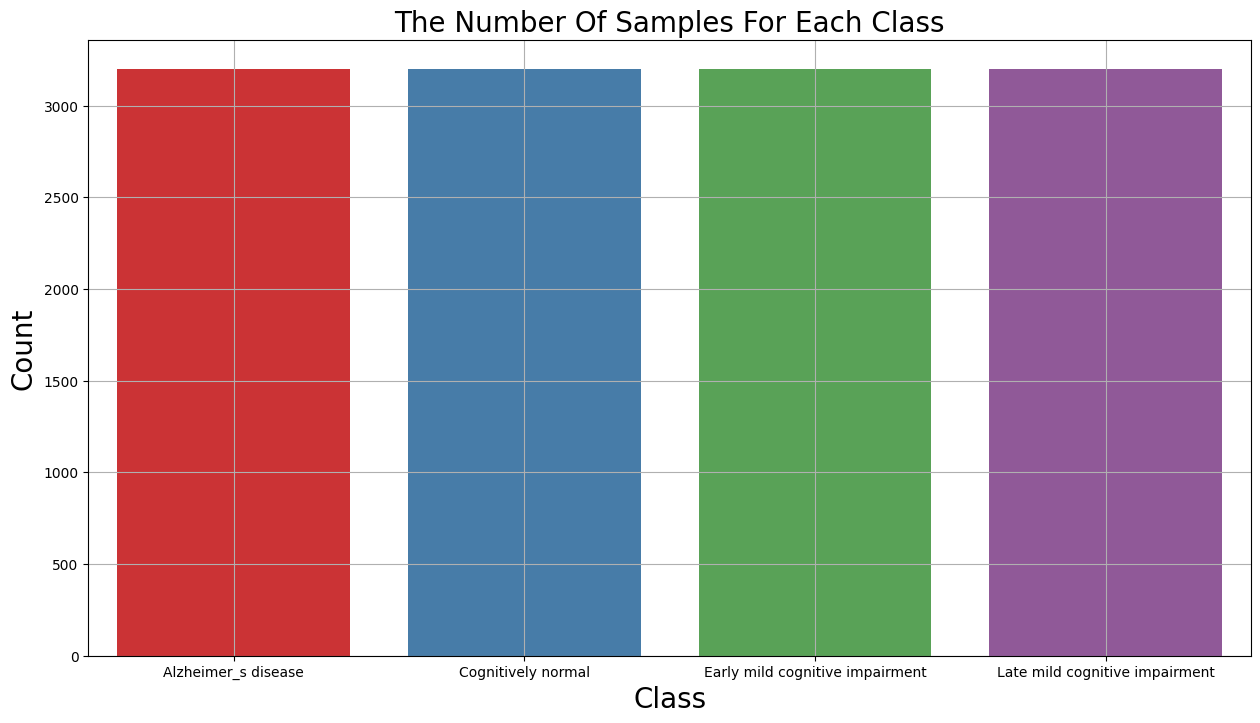

In [11]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1' ,hue=labels,legend=False)
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.show()

Splitting the data into training, validation, and test sets while ensuring that the class distribution is maintained in each split using Stratify

In [12]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


In [13]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 44, 44, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

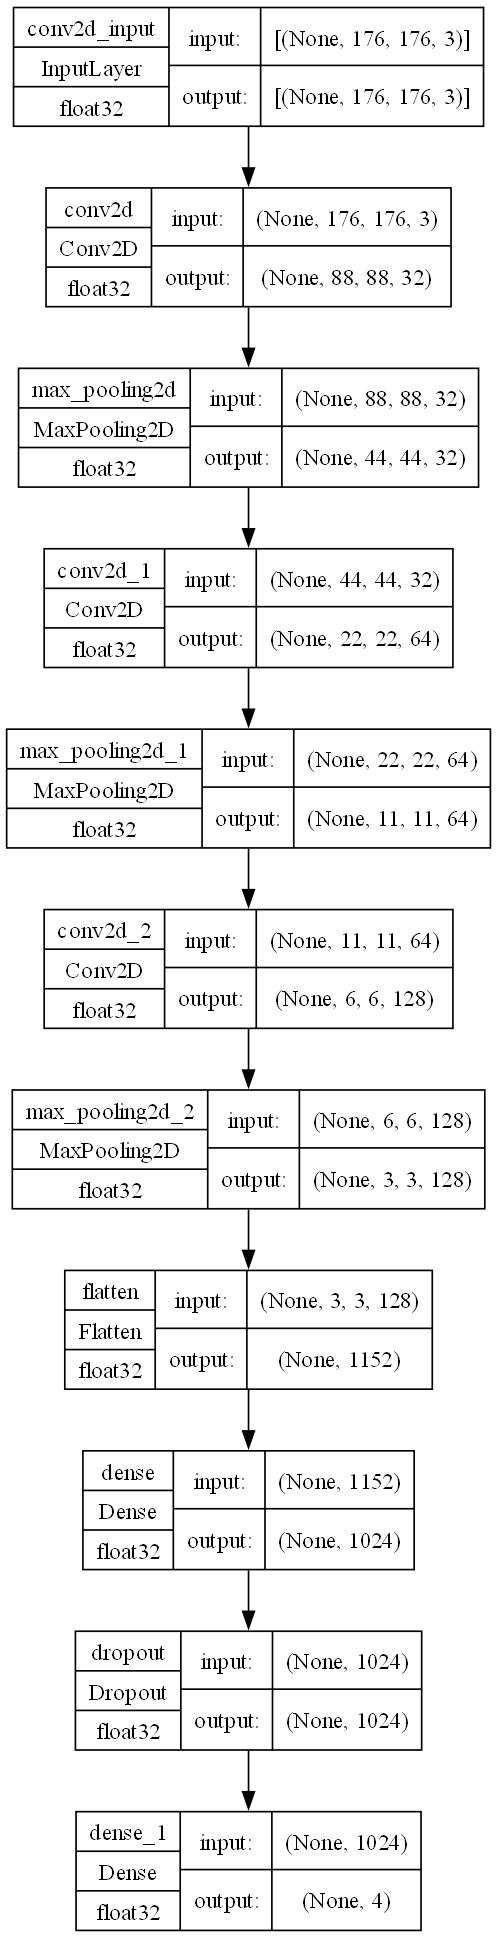

In [15]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [16]:
checkpoint_cb =ModelCheckpoint("CNN_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
280/280 [==============================] - 18s 59ms/step - loss: 0.8432 - accuracy: 0.5913 - val_loss: 0.5758 - val_accuracy: 0.7432
Epoch 2/50


C:\Users\Krishang Virmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 15s 52ms/step - loss: 0.4271 - accuracy: 0.8062 - val_loss: 0.3555 - val_accuracy: 0.8328
Epoch 3/50
280/280 [==============================] - 14s 52ms/step - loss: 0.2531 - accuracy: 0.8934 - val_loss: 0.2067 - val_accuracy: 0.9219
Epoch 4/50
280/280 [==============================] - 14s 50ms/step - loss: 0.1575 - accuracy: 0.9363 - val_loss: 0.1295 - val_accuracy: 0.9479
Epoch 5/50
280/280 [==============================] - 14s 50ms/step - loss: 0.0931 - accuracy: 0.9669 - val_loss: 0.3505 - val_accuracy: 0.8813
Epoch 6/50
280/280 [==============================] - 14s 50ms/step - loss: 0.0801 - accuracy: 0.9700 - val_loss: 0.1242 - val_accuracy: 0.9557
Epoch 7/50
280/280 [==============================] - 14s 51ms/step - loss: 0.0489 - accuracy: 0.9830 - val_loss: 0.0814 - val_accuracy: 0.9708
Epoch 8/50
280/280 [==============================] - 14s 50ms/step - loss: 0.0480 - accuracy: 0.9839 - val_loss: 0.1166 - val_accuracy: 0.9599
Epo

In [17]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   0.843153  0.591295  0.575786      0.743229
1   0.427055  0.806250  0.355503      0.832812
2   0.253133  0.893415  0.206736      0.921875
3   0.157484  0.936272  0.129456      0.947917
4   0.093134  0.966853  0.350542      0.881250
5   0.080067  0.969978  0.124201      0.955729
6   0.048925  0.983036  0.081373      0.970833
7   0.048040  0.983929  0.116608      0.959896
8   0.042385  0.984710  0.105375      0.966667
9   0.018246  0.993862  0.105176      0.971875
10  0.032530  0.989397  0.147981      0.957292
11  0.043373  0.984821  0.088119      0.979167
12  0.027214  0.991406  0.109788      0.969271
13  0.032755  0.987165  0.073179      0.977083
14  0.014213  0.994978  0.077100      0.975521
15  0.016239  0.993192  0.089906      0.975000
16  0.021568  0.992634  0.069818      0.981771
17  0.018284  0.993750  0.087130      0.975521
18  0.020429  0.992522  0.089339      0.976042
19  0.030350  0.989732  0.078352      0.980208
20  0.021530  0.992857  0.077871      0.976042
21  0.007256  0.997656  0.053846      0.981771
22  0.002386  0.998996  0.069851      0.983333
23  0.021498  0.993527  0.117770      0.970312
24  0.035682  0.988504  0.097349      0.974479
25  0.012098  0.995647  0.109361      0.972917
26  0.017773  0.994085  0.221254      0.951042
27  0.018221  0.994308  0.059331      0.986458
28  0.000405  1.000000  0.067303      0.986458
29  0.000112  1.000000  0.059120      0.988021
30  0.000043  1.000000  0.056591      0.987500
31  0.000027  1.000000  0.057014      0.988021

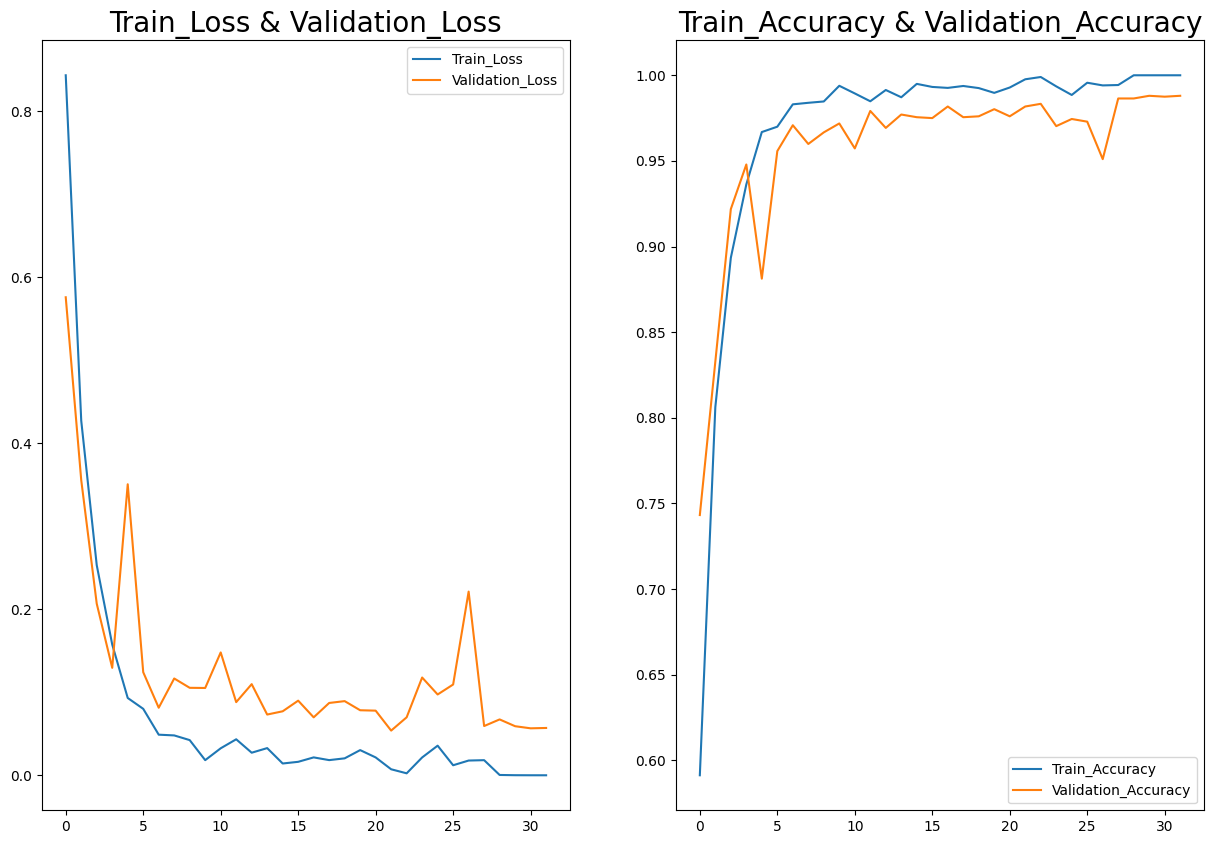

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [19]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 1s 18ms/step - loss: 0.0594 - accuracy: 0.9891
Test Loss = 0.059389688074588776
Test Accuracy = 0.989062488079071


In [20]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 1s 17ms/step


Actual  Prediction
0          1           1
1          1           1
2          0           0
3          2           2
4          2           2
...      ...         ...
1915       2           2
1916       0           0
1917       2           2
1918       3           3
1919       3           3

[1920 rows x 2 columns]

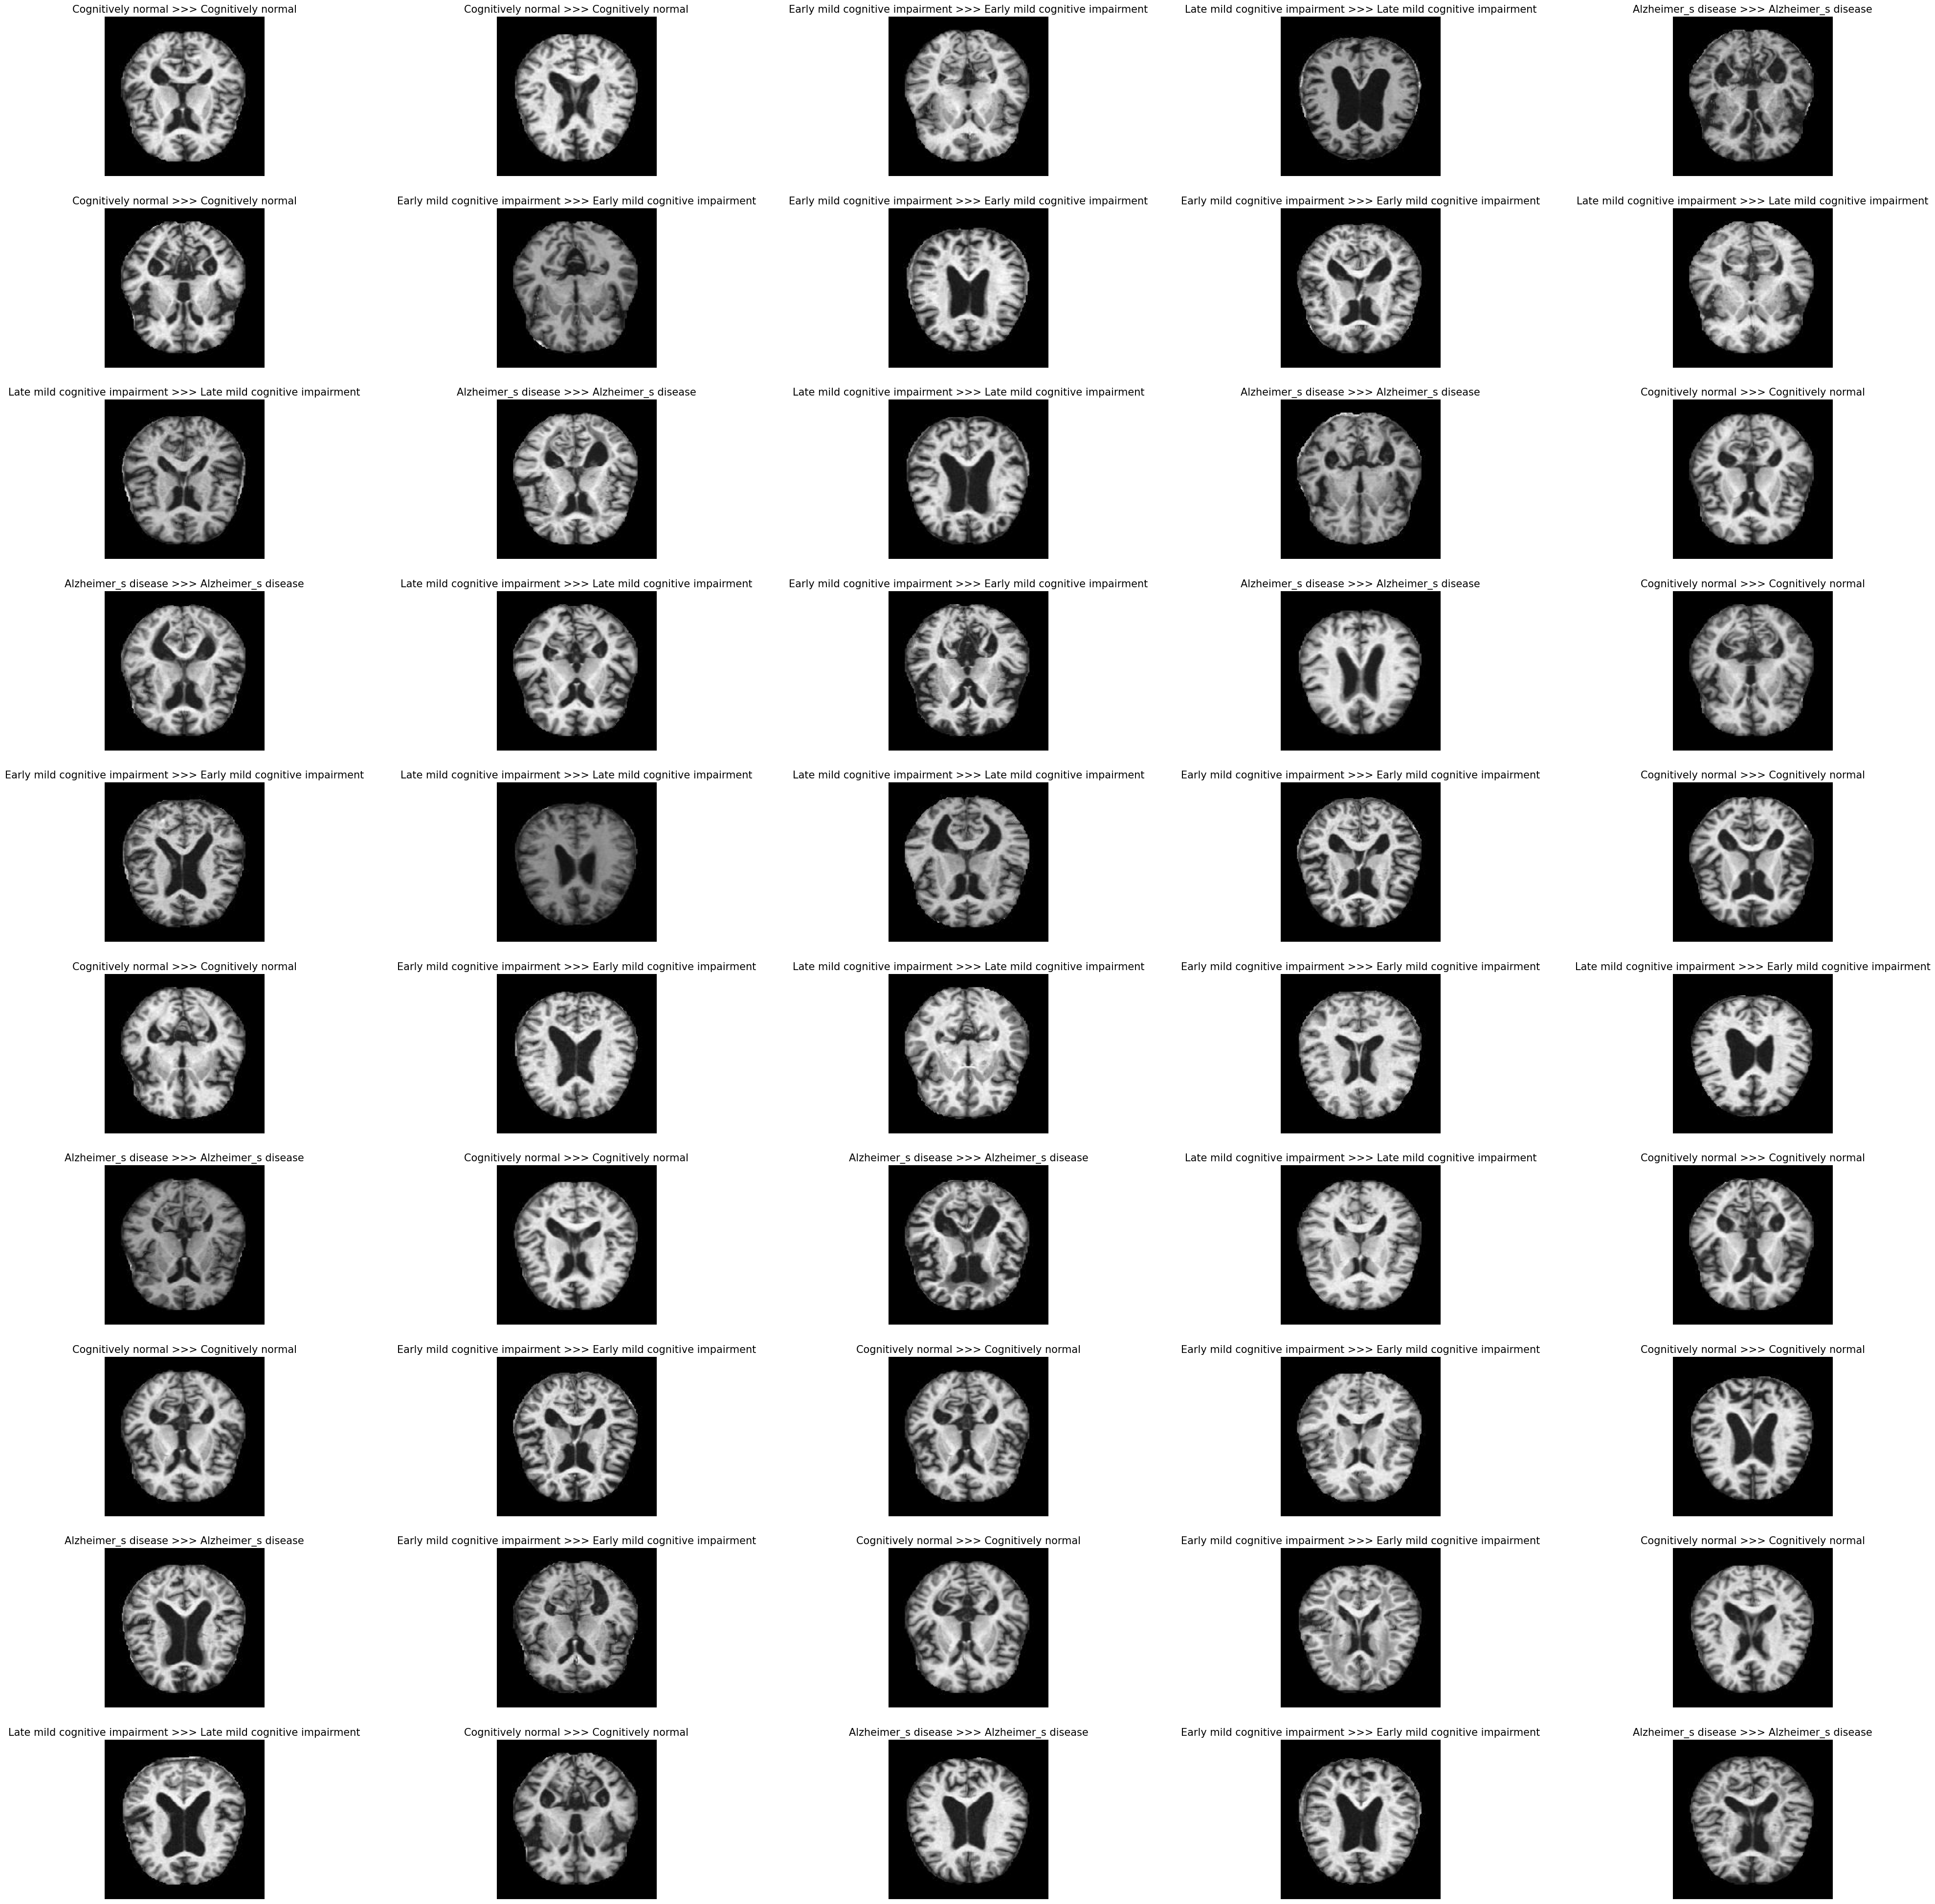

In [21]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

array([[480,   0,   0,   0],
       [  0, 480,   0,   0],
       [  3,   0, 474,   3],
       [  0,   0,  15, 465]], dtype=int64)

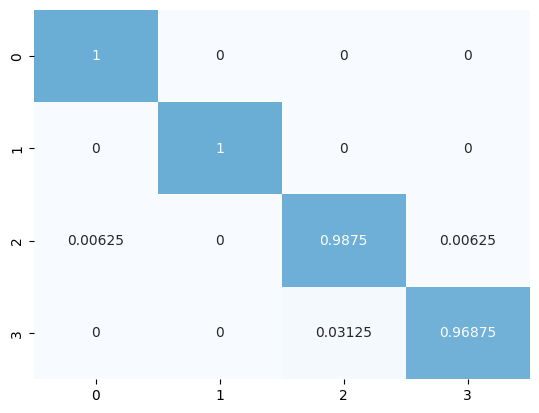

In [22]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [23]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      1.00      1.00       480
           1       1.00      1.00      1.00       480
           2       0.97      0.99      0.98       480
           3       0.99      0.97      0.98       480

    accuracy                           0.99      1920
   macro avg       0.99      0.99      0.99      1920
weighted avg       0.99      0.99      0.99      1920

